## Project 2018 - "Programming For Data Analysis"

### A Notebook by: Marco Men

### Date Of Last Commit: 14th December 2018

## Introduction

In this notebook I will be choosing a  real-world phenomenon ( stock price fluctuations ) and strategy creation based on real data.
I will be :
 *  Investigating the types of variables involved ( their distributions and relationships with each other ) ;
 *  Simulating/synthesising the dataset as closely matching their properties as possible ;
 *  And detailing my research and implement the simulation in this Jupyter notebook .

Before I continue, I must give you some insight on the Python package used to download and retrieve the historical stock information ( S&P500 ) and why. 

The package I am refering to is called "fix-yahoo-finance", created by Ran Aroussi to provide a fix to "Pandas Datareader ( "get_data_yahoo()" ) . This Pandas Datareader command relied on Yahoo!Finance API, which has been decommissioned after AOL's acquisition of Yahoo.

This package must be installed on your machine, if you intend to download/clone this notebook and run it locally.

As the package is not part of Anaconda version of python, only pip install works ( not conda install ). More information can be found [here](https://pypi.org/project/fix-yahoo-finance/). 

If the previous method does not work, an alternative method is to clone a [GitHub folder](https://github.com/ranaroussi/fix-yahoo-finance) into your machine and run either "python setup.py install" inside your cloned folder.


# The Story For The Simulation

I believe every simulation should start with a story. The story is fictitious, so I had to use my imagination and creativity.

Let's say I work in a stock trading firm in the "quant" department. I was asked to investigate Nissan's stock price fluctuations and come up with potential outcomes for next year, based on Nissan's stock price history.


## Market Log Returns


The reason for this paragraph is because I will be simulating stock prices and log returns, which will be based onb the Close Stock Prices. The Close variables will be given and constant ( on a daily basis ). The Log Returns will be calculated based on the difference of the stock returns for two consecutive periods. Which in the case depicted in this notebook will be daily returns. The first period will be given a 0 amount, through programming in Pandas, otherwise I would end up with a NaN. This is because there is not a prior period for the calulation of period differences.

The following example was retrieved from [investopedia's](https://www.investopedia.com/articles/investing/102014/lognormal-and-normal-distribution.asp) website:

An investor wants to know an expected future stock price. Since stocks grow at a compounded rate, she needs to use a growth factor. To calculate possible expected prices, she will take the current stock price and multiply it by various rates of return (which are mathematically derived exponential factors based on compounding) and which are assumed to be normally distributed. When the investor continuously compounds the returns, she creates a lognormal distribution which is always positive, even if some of the rates of return are negative, which will happen 50% of the time in a normal distribution. The future stock price will always be positive because stock prices cannot fall below $0.

The formula for the **logarithmic or continuously compounded return** is :

$$ R = ln \bigg(\frac {V_f} {V_i}\bigg)$$

Where

$V_f = Final Value ( including\ dividends\ an\ interest )$

$V_i = Initial Value ( Yesterday's\ Closing\ Value ) $

A good article on **market log returns** can be found in [quantivity](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).

The other method would be calculating **percentage changes in prices**, which is depicted by the following formula:

$$ \frac{P_1 - P_2} {P_1} * 100 $$

Where:

$ P_1 = Yesterday's \ Closing\ Price \\
 P_2 = Today's\ Closing\ Price $

[financetrain](https://financetrain.com/why-lognormal-distribution-is-used-to-describe-stock-prices/) website. 

In [2]:
# https://stackoverflow.com/questions/49705047/downloading-mutliple-stocks-at-once-from-yahoo-finance-python

import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
import matplotlib.pyplot as plt

yf.pdr_override()



# Nissan stock prices
tickers = ['NSANY']

start_date = '2017-07-15'
end_date = '2018-12-05'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
nis = pdr.get_data_yahoo(tickers,start=start_date, end=end_date)
nis.info()

[*********************100%***********************]  1 of 1 downloaded
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2017-07-14 to 2018-12-04
Data columns (total 6 columns):
Open         352 non-null float64
High         352 non-null float64
Low          352 non-null float64
Close        352 non-null float64
Adj Close    352 non-null float64
Volume       352 non-null int32
dtypes: float64(5), int32(1)
memory usage: 17.9 KB


There is a 'Close' and 'Adjusted Close' columns. The main difference between these two columns is that 'Close' column is *ex-dividends* ( before any dividends are paid ) and the 'Adjusted Close' is *post-dividends*. I am interested in the *ex-dividends* 'Close' column. Some investment managers use the 'Adjusted Close' as they claim it provides a more realistic view, but in a forecast scenario, the investor has no input nor knowledge of what dividends will be paid in the future. Also, pointing to the formula mentioned above, the *final value includes dividends and interest*.

Now I will check what type of distribution the 'Close' column forms, by plotting its density and gather information from the descriptive statistics to be used in my modelling ( standard deviation and mean ). And then I will see what type of log returns ('Market' column ) plot Nissan has.

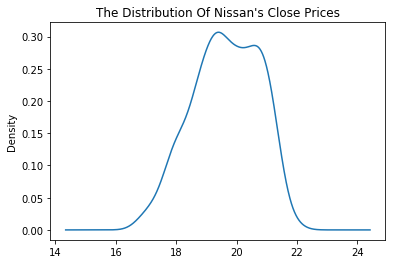

In [3]:
# The real Nissan close prices distribution
plt.title('The Distribution Of Nissan\'s Close Prices')
nis['Close'].plot.density()

In [18]:
nis.Close.describe()

count    352.000000
mean      19.637926
std        1.099276
min       16.860001
25%       18.860001
50%       19.644999
75%       20.590000
max       21.900000
Name: Close, dtype: float64

I will use the information from the summary of descriptive statistics to simulate the 'Close' columns. In my simulations I will make a dataset with 350 counts, with an approximate mean of 19.63 and **normally-distributed**. I will follow the guidance from [numpy's](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.normal.html) website.

In [4]:
# Simulation of 'Close' column

de_1 = pd.Series(1.09 *np.random.normal(0,1,350) + 19.63,name = 'Original_Close')


de_2 = pd.Series(1.09 * np.random.normal(0,2,350) + 19.63,name = 'Sample_Close')


de_3 = pd.Series(1.09 * np.random.normal(0,3,350) + 19.63,name = 'Mine_Close')



df = pd.concat([de_1,de_2,de_3],axis = 1)

# Create a time series index from the dataframes above

dates = pd.date_range('1/1/2018', periods=350, freq='D')



# Setting dates as index for data

df.index = dates
df = df.rename_axis('Date', axis=1)

df.info()

df.head()
 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2018-01-01 to 2018-12-16
Freq: D
Data columns (total 3 columns):
Original_Close    350 non-null float64
Sample_Close      350 non-null float64
Mine_Close        350 non-null float64
dtypes: float64(3)
memory usage: 10.9 KB


Date,Original_Close,Sample_Close,Mine_Close
2018-01-01,19.210782,15.503788,20.422194
2018-01-02,18.920781,18.282568,18.906294
2018-01-03,22.439025,19.922549,16.831294
2018-01-04,19.341307,22.618649,14.505242
2018-01-05,19.860039,21.200702,15.523960


# The Sinthesised Dataset

The dataset simulated above is based on Nissan stock price fluctuation. The "Close" columns are based on the distribution of Nissan real Close column from 14/07/2017 until 04/12/2018, with minor adjustments to the  $ \sigma $ values ( or **standard deviation** ) for each of the simulated companies.

One point I must make, is that the standard deviation in the case of stock or economic markets represents **volatility**. In other words, the level of risks the market is subject to, will influence the fluctuation prices. The higher the standard deviation ( or volatility or risks ), the more stock prices will fluctuate. You will see this depicted at the end of this notebook.  

Now let us check the density distribution of 3 fake companies Close prices.

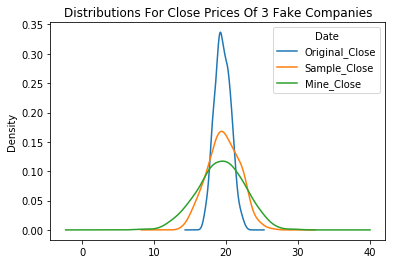

In [7]:

df.plot.density()
plt.title('Distributions For Close Prices Of 3 Fake Companies')
plt.show()

The 'Original_Close' seems to be a good approximation of Nissan('Close') real information. 'Sample_Close' and 'Mine_Close' are slightly lower because of the standard deviation or Market volatility.

Next, I will calculate Market Log Returns from Nissan's 'Close' column and then plot its density distribution. And after that try and create similar type of information on my simulated dataset ( Rets. ) to plot them. The Market Returns is simply calculated with the following formula :

$\log \bigg(\frac{Closing\ Price(Yesterday)}{Closing\ Price(Today)} \bigg)$ 

This is because the Close Price column is **normally distributed** and its returns are an approximation **log normal** distribution. A very good explanation can be found in [Quantitivity](https://quantivity.wordpress.com/2011/02/21/why-log-returns/).


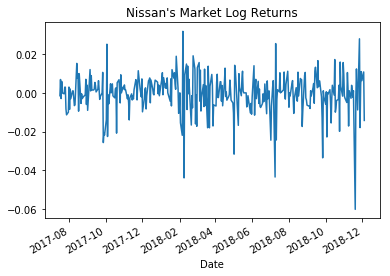

In [8]:
 # Another way to calculate log returns and we drop the NAs
    
nis['Market'] = np.log(nis.Close).diff()

nis = nis.dropna()


# The Market log returns

plt.figure()
nis.Market.plot()
plt.title('Nissan\'s Market Log Returns')
plt.show()

A classical daily return plot. Let me focus your attention to the lowest point,it may be due to recent scandals regarding Board Members,CEO and Chairman. Remember that we are dealing with real historical stock data for Nissan.

Next let us  check the density plot.

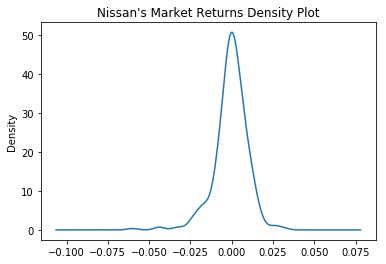

In [9]:
# The real Nissan market returns density plot

plt.figure()
nis.Market.plot.density()
plt.title('Nissan\'s Market Returns Density Plot')
plt.show()

The distribution of market log returns appears to be normal distribution with mean around than 0 and standard deviation of around 0.025. But as being the sceptical that I am, I will double check by asking Pandas. Depending on the results I will get, I will eiter use randn or random_normal. I will be following numpy.org guidance when generating numbers ( pseudo ) randomly. So, I will need the standard deviation and the mean of the distribution above. I will ask Pandas to give me a description of summary statistics.

In [81]:
nis.Market.describe()

count    347.000000
mean      -0.000458
std        0.010143
min       -0.060277
25%       -0.004714
50%        0.000000
75%        0.005295
max        0.031839
Name: Market, dtype: float64

In [11]:


# Simulation of 'Log Returns'

d1 = pd.Series( np.log(de_1).diff() ,name ='Original_Rets')
d2 = pd.Series( np.log(de_2).diff(),name ='Sample_Rets')
d3 = pd.Series( np.log(de_3).diff(),name ='Mine_Rets')


df2 = pd.concat([d1,d2,d3],axis=1)
df2 = df2.fillna(0)  # Fill NA with 0 for the first row

# Create a time series index from the dataframes above

dates = pd.date_range('1/1/2018', periods=350, freq='D')


# Setting dates as index for data

df2.index = dates
df2 = df2.rename_axis('Date', axis=1)



df2.info()

df2.head()

df2.describe()



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2018-01-01 to 2018-12-16
Freq: D
Data columns (total 3 columns):
Original_Rets    350 non-null float64
Sample_Rets      350 non-null float64
Mine_Rets        350 non-null float64
dtypes: float64(3)
memory usage: 10.9 KB


Date,Original_Rets,Sample_Rets,Mine_Rets
count,350.000000,350.000000,350.000000
mean,0.000392,0.000716,-0.000015
std,0.076079,0.162759,0.246944
min,-0.190548,-0.516813,-0.789167
25%,-0.051799,-0.111602,-0.150275
50%,-0.003195,-0.000237,0.002502
75%,0.056039,0.119490,0.136380
max,0.219987,0.461890,0.945292


They are a quite good approximation of Nissan's data. Especially Original's Returns. The log returns are merely calculated from the Close variables in my simulate( sinthesised ) dataset for each of the fake companies.

<Figure size 432x288 with 0 Axes>

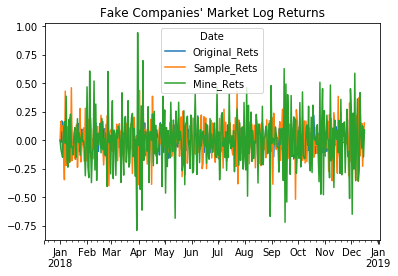

In [12]:
# Now the Log Returns plot

plt.figure()
df2.plot()
plt.title('Fake Companies\' Market Log Returns')
plt.show()

The plot above represents fluctuations of stock price percentages from one day to the next.

The intervals are from -0.08 to +0.08. On the actual Nissan plot ( above ) the interval is from -0.06 to +0.03.

<Figure size 432x288 with 0 Axes>

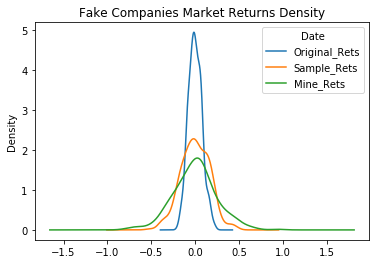

In [13]:
# Simulated market log returns distributions for fake companies

plt.figure()
df2.plot.density()
plt.title('Fake Companies Market Returns Density')
plt.show()

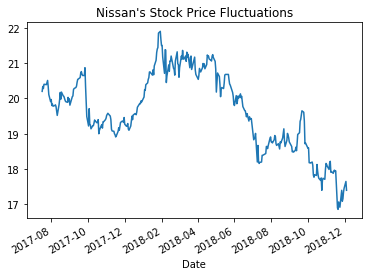

In [15]:
# Stock price fluctuations for Nissan

plt.figure()
nis['Close'].plot()
plt.title('Nissan\'s Stock Price Fluctuations')
plt.show()

<Figure size 432x288 with 0 Axes>

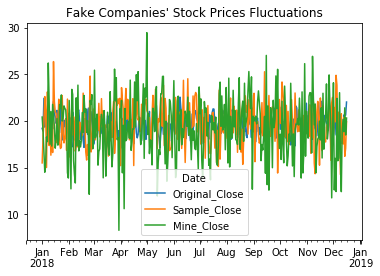

In [16]:
# Close stock price fluctuations

plt.figure()
df.plot()
plt.title('Fake Companies\' Stock Prices Fluctuations')
plt.show()

The plot above shows 3 simulations of potential variations of Nissan closing prices.
Mine PLC is the one company that presents the highest variance in terms of fluctuation of stock closing prices and then Sample PLC and the Original PLC plot is quite close to Nissan's data. This is made clear on the density graphs plotted above.

With this simulation, I can see the possible variations that the stock price can have in the future under current conditions.

Mine PLC would represent a market fluctuation with **high** risk and uncertainty, Sample PLC with **medium** risk.

The distributions used for the simulation was on a different scale. I used Nissan's close prices for 18 years, whereas my simulation is for less than 1 year.

Of course, Mine PLC represents a very unrealistic and unlikely scenario. Even though it is possible for a company to be subject to such fluctuations, they would not be  as evident in a timeframe of 350 days ( it would have to be several years ). The risks referred here could be scandal regarding key employees,changes of Directors, business extremely subject to seasonality components and/or differences of economic environment ( high levels of economic expansion followed by extremely low economic reccessions ). All those conditions are highly unlikely within 350 days.

Next, I will re organise my dataset with a DateTimeIndex from 01/01/2018 with a daily frequency for 350 days ( until 16/12/2018 )

In [68]:
# Re organising my DS

Original = pd.concat([de_1,d1],axis=1)
Original = Original.fillna(0)

Sample = pd.concat([de_2,d2],axis=1)
Sample = Sample.fillna(0)

Mine = pd.concat([de_3,d3],axis=1)
Mine= Mine.fillna(0)

# Create a time series index from the dataframes above

dates = pd.date_range('1/1/2019', periods=350, freq='D')
data = pd.concat([Original,Sample,Mine],axis=1, join='inner')
data = data.fillna(0)  # Fill NA with 0 for the first row


# Setting dates as index for data

data.index = dates
data = data.rename_axis('Date', axis=1)

data.info()

data.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 350 entries, 2019-01-01 to 2019-12-16
Freq: D
Data columns (total 6 columns):
Original_Close    350 non-null float64
Original_Rets     350 non-null float64
Sample_Close      350 non-null float64
Sample_Rets       350 non-null float64
Mine_Close        350 non-null float64
Mine_Rets         350 non-null float64
dtypes: float64(6)
memory usage: 19.1 KB


Date,Original_Close,Original_Rets,Sample_Close,Sample_Rets,Mine_Close,Mine_Rets
2019-01-01,20.369390,0.000000,18.151895,0.000000,19.847262,0.000000
2019-01-02,20.256810,-0.005542,20.520311,0.122640,22.459293,0.123638
2019-01-03,19.074284,-0.060150,23.863916,0.150952,14.774204,-0.418822
2019-01-04,20.581726,0.076063,20.329433,-0.160298,20.165535,0.311092
2019-01-05,19.693825,-0.044098,18.241993,-0.108343,16.246052,-0.216125


## Conclusion

To recap, I have created a dataframe of 3 fake companies with Close Prices and Market Log Returns for each  based on the real Nissan historical stock prices( 'Close' column ). I also, included a TimeSeries index with 350 daily periods to my DataFrame from 01/01/2019 until 16/12/2019 ( most of next year ). 

I would like to remind you about the close relationship between the **Normal and Lognormal Distribution**. The **lognormal** distribution is by definition a random variable whose natural logarithm is **normally distributed**.

In the dataset above, there are 2 columns ( variables ) for each of the fake companies. The "\_Close" columns represent **normally distributed** variables and the "\_Rets columns are lognormal distributions of the respective companies' 'Close' columns.

I do not work for a Stock Trading firm and I am not a "quant", but I wanted to demonstrate the simulation of a time series and stock price movements are ideal for it. And also, carry research regarding probability distributions in stock movements.

One thing I learned in particular, is that **normal distribution** is "frowned" upon for being too simplistic in the area of financial modelling and engineering. At the same time is the most used distribution in this particular field of algorithm trading.


## Literature Review & References

'Python For Finance'- Yves Hilpisch

[DataCamp](https://www.datacamp.com/community/tutorials/finance-python-trading?utm_source=adwords_ppc&utm_campaignid=898687156&utm_adgroupid=48947256715&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=261400735633&utm_targetid=aud-392016246653:dsa-473406585355&utm_loc_interest_ms=&utm_loc_physical_ms=20480&gclid=EAIaIQobChMI44eskMuI3wIVjEPTCh33TgFgEAAYASAAEgJxBvD_BwE)

[QuantConnect](https://www.quantconnect.com/tutorials/tutorial-series/introduction-to-financial-python)


